# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
!conda update pandas -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.0.2p             |       h470a237_2         3.1 MB  conda-forge
    pandas-0.23.4              |   py36hf8a1672_0        27.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        30.9 MB

The following packages will be UPDATED:

  ca-certificates                               2017.11.5-0 --> 2018.11.29-ha4d7672_0
  certifi                                  2017.11.5-py36_0 --> 2018.11.29-py36_1000
  openssl                                          1.0.2n-0 --> 1.0.2p-h470a237_2
  pandas                                      0.20.3-py36_1 --> 0.23.4-py36hf8a1672_0



openssl-1.0.2p       | 3.1 MB    | ############################

Prepare Data: import the necessary library and load the data. 

In [23]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.cluster import KMeans
from sklearn.preprocessing import Imputer,StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
% matplotlib inline
import matplotlib.pyplot as plt

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [24]:
portfolio['percentage'] = portfolio['reward']/portfolio['difficulty']
#转为百分比

The first thing i try to figure out is how the offer looks like:

In [25]:
portfolio

,channels,difficulty,duration,id,offer_type,reward,percentage
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1.000000
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1.000000
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,NaN
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1.000000
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0.250000
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,0.428571
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,0.200000
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,NaN
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1.000000
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,0.200000


Turn the transcript to two parts:transcript_offer and transcript_amount

In [26]:
#记录index和value的值，判定offer还是amount，新增列，两个pdframe
test = []
test1 = []
a = transcript.value.values
for i in transcript.index:
    if str(a[i])[2:10] == 'offer id':
        test.append(i)
        test1.append(str(a[i])[14:-2])
        
      

In [27]:
col = []
ammount = []
for i in transcript.index:
    if str(a[i])[2:8] == 'amount':
        col.append(i)
        ammount.append(str(a[i])[11:-1])

In [28]:
transcript_offer = transcript.loc[test,:]
transcript_amount = transcript.loc[col,:]

In [29]:
transcript_offer['offerid'] = test1
transcript_amount['amount'] = ammount

In [30]:
transcript_offer = transcript_offer.drop(['value'], axis=1)
transcript_amount = transcript_amount.drop(['value'], axis=1)

In [31]:
transcript_offer1 = transcript_offer.groupby(['offerid','event'])['person'].count().unstack()
transcript_offer1['percentage'] = transcript_offer1['offer viewed']/transcript_offer1['offer received']
transcript_offer1 = transcript_offer1.sort_values(by = ['percentage'])
transcript_offer1 = pd.merge(portfolio,transcript_offer1,right_on =transcript_offer1.index ,left_on='id')
transcript_offer1 = transcript_offer1.sort_values(by = ['percentage_y'])


In [32]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


find the describation of sex and clean it

In [33]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

([<matplotlib.patches.Wedge at 0x7f04f30fcbe0>,
 [Text(-1.0693,0.544606,'female'),
  Text(1.00027,-0.567409,'male'),
  Text(0.778024,0.846864,'other')],
 [Text(-0.623759,0.317687,'57.2%'),
  Text(0.565372,-0.32071,'41.3%'),
  Text(0.439753,0.478662,'1.4%')])

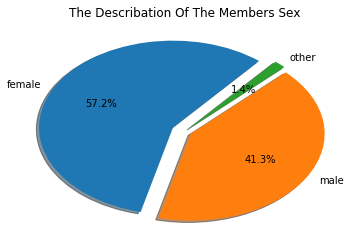

In [34]:
df_pie = profile.gender.value_counts()
labels=['female','male','other']
explode=0.1,0.05,0.05
plt.title('The Describation Of The Members Sex')
plt.pie(df_pie,explode=explode,labels=labels,autopct='%1.1f%%',shadow=True,startangle=50)

In [35]:
profile.gender = profile.gender.replace('M',1)
profile.gender = profile.gender.replace('F',2)
profile.gender = profile.gender.replace('O',3)
profile.gender = profile.gender.replace('None',0)
profile.gender = profile.gender.replace(np.NaN,0)

find the describation of age and try to clean them 

In [36]:
profile.age = profile.age.replace([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],' 20')
profile.age = profile.age.replace([21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40],'21~40')
profile.age = profile.age.replace([41,42,43,44,45,46,47,48,49,50],'41~50')
profile.age = profile.age.replace([51,52,53,54,55,56,57,58,59,60],'51~60')
profile.age = profile.age.replace([61,62,63,64,65,66,67,68,69,70],'61~70')
profile.age = profile.age.replace([71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90],'71~90')
profile.age = profile.age.replace([91,92,93,94,95,96,97,98,99,100,101],'90 ')
profile.age = profile.age.replace(118,'Unknown')


In [37]:
profileage1 = profile.age.value_counts()

<Container object of 8 artists>

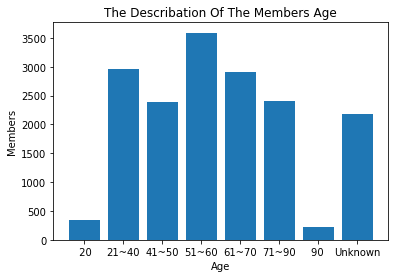

In [38]:
labels   = profileage1.index.tolist()
 
quants   = profileage1.values.tolist()
plt.xlabel('Age')
plt.ylabel('Members')
plt.title('The Describation Of The Members Age')
plt.bar(labels,quants)

In [39]:
profile.age = profile.age.replace('Unknown',0)
profile.age = profile.age.replace(' 20',1)
profile.age = profile.age.replace('21~40',2)
profile.age = profile.age.replace('41~50',3)
profile.age = profile.age.replace('51~60',4)
profile.age = profile.age.replace('61~70',5)
profile.age = profile.age.replace('71~90',6)
profile.age = profile.age.replace('90 ',7)

In [40]:
profile.age.value_counts()

4    3590
2    2962
5    2910
6    2413
3    2391
0    2175
1     340
7     219
Name: age, dtype: int64

find the describation of income and try to clean them 

In [41]:
profile.income = profile.income.replace([30000,31000,32000,33000,34000,35000,36000,37000,38000,39000,40000],'30K~40K')
profile.income = profile.income.replace([41000,42000,43000,44000,45000,46000,47000,48000,49000,50000],'41K~50K')
profile.income = profile.income.replace([51000,52000,53000,54000,55000,56000,57000,58000,59000,60000],'51K~60K')
profile.income = profile.income.replace([61000,62000,63000,64000,65000,66000,67000,68000,69000,70000],'61K~70K')
profile.income = profile.income.replace([71000,72000,73000,74000,75000,76000,77000,78000,79000,80000],'71K~80K')
profile.income = profile.income.replace([81000,82000,83000,84000,85000,86000,87000,88000,89000,90000],'81K~90K')
profile.income = profile.income.replace([91000,92000,93000,94000,95000,96000,97000,98000,99000,100000],'91K~100K')
profile.income = profile.income.replace([101000,102000,103000,104000,105000,106000,107000,108000,109000,110000,111000,112000,113000,114000,115000,116000,117000,118000,119000,120000],'101K~120K')

In [42]:
profileincome1 = profile.income.value_counts()

<Container object of 8 artists>

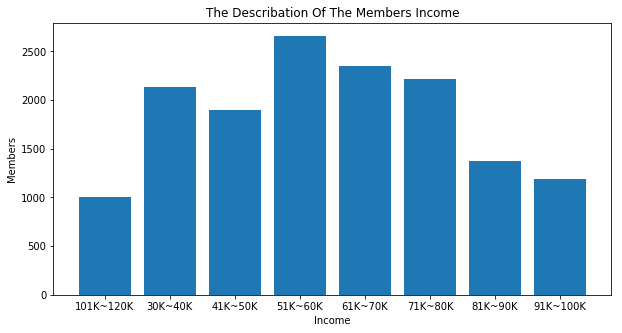

In [43]:
labels   = profileincome1.index.tolist()
 
quants   = profileincome1.values.tolist()
fig=plt.figure(figsize=(10,5))
plt.xlabel('Income')
plt.ylabel('Members')
plt.title('The Describation Of The Members Income')
plt.bar(labels,quants)

In [44]:
profile.income = profile.income.replace('30K~40K',1)
profile.income = profile.income.replace('41K~50K',2)
profile.income = profile.income.replace('51K~60K',3)
profile.income = profile.income.replace('61K~70K',4)
profile.income = profile.income.replace('71K~80K',5)
profile.income = profile.income.replace('81K~90K',6)
profile.income = profile.income.replace('91K~100K',7)
profile.income = profile.income.replace('101K~120K',8)
profile.income = profile.income.replace(np.NaN,0)

In [45]:
profile.income.value_counts()

3.0    2659
4.0    2347
5.0    2220
0.0    2175
1.0    2135
2.0    1899
6.0    1371
7.0    1188
8.0    1006
Name: income, dtype: int64

replace the became_member_on to how many years the member join the starbucks

In [46]:
profile.became_member_on = profile.became_member_on.values/10000
profile.became_member_on = profile.became_member_on.values.round()


In [47]:
a = 2018 - profile.became_member_on

In [48]:
profile.became_member_on = a

In [49]:
profile1 = profile.drop('id', axis = 1)

In [50]:
profile1.head()

,age,became_member_on,gender,income
0,0,1.0,0.0,0.0
1,4,1.0,2.0,8.0
2,0,0.0,0.0,0.0
3,6,1.0,2.0,7.0
4,0,1.0,0.0,0.0


Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features.

In [51]:
imp = Imputer(missing_values='NaN', strategy='median', axis=0, verbose=0, copy=False)
imp.fit(profile1)
profile1_imp = imp.transform(profile1)

In [52]:
ss = StandardScaler(copy=True, with_mean=True, with_std=True)
ss.fit(profile1_imp)
profile1_ss = ss.transform(profile1_imp)

now ready to apply dimensionality reduction techniques

In [53]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca


def plot_components(X, y):
    '''
    plots the data in a 2 dimensional space to view separation
    INPUT: X - the x-matrix of input features
           y - the response column 
    OUTPUT: none
    '''
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure(figsize=(10, 6))
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]), color=plt.cm.Set1(y[i]), fontdict={'size': 15})

    plt.xticks([]), plt.yticks([]), plt.ylim([-0.1,1.1]), plt.xlim([-0.1,1.1])

    
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

def plot_component(pca, comp):
    '''
    Plots an image associated with each component to understand how the weighting 
    of the components 
    INPUT: 
          pca - pca object created from PCA in sklearn
          comp - int - the component you want to see starting at 0
    OUTPUT
          None
    '''
    if comp <= len(pca.components_):
        mat_data = np.asmatrix(pca.components_[comp]).reshape(100,100)  #reshape images
        plt.imshow(mat_data); #plot the data
        plt.xticks([]) #removes numbered labels on x-axis
        plt.yticks([]) #removes numbered labels on y-axis   
    else:
        print('That is not the right input, please read the docstring before continuing.')
        

def pca_results(full_dataset, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (14,8))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)


In [54]:
pca,profile1_pca = do_pca(4,profile1_ss)

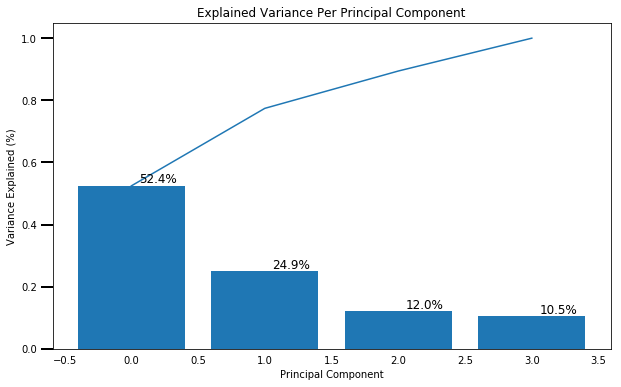

In [55]:
scree_plot(pca)


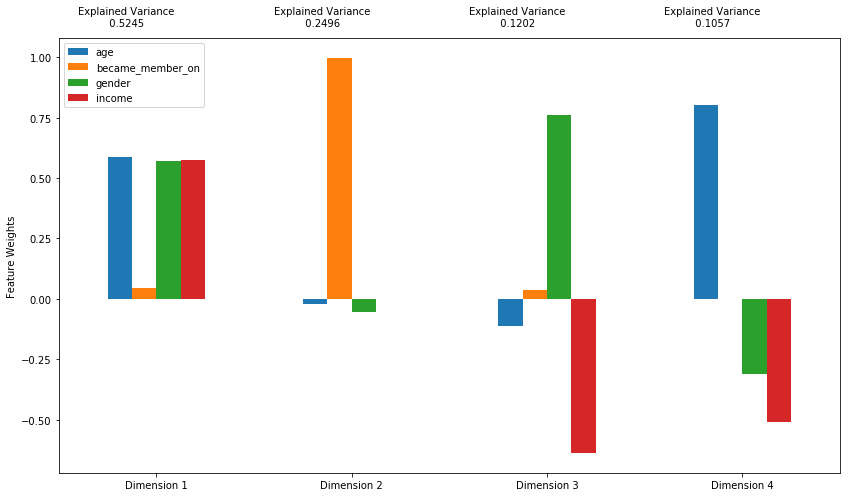

In [56]:
profile1_results = pca_results(profile1, pca)

In [57]:
component1 = profile1_results.head(4)
component1 = component1.T
component1.sort_values(by = 'Dimension 1',ascending=False).head(5)

,Dimension 1,Dimension 2,Dimension 3,Dimension 4
age,0.5864,-0.0218,-0.1141,0.8016
income,0.5749,-0.0029,-0.6386,-0.5115
gender,0.5689,-0.0531,0.7601,-0.3094
Explained Variance,0.5245,0.2496,0.1202,0.1057
became_member_on,0.0448,0.9983,0.0361,-0.0004


will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep

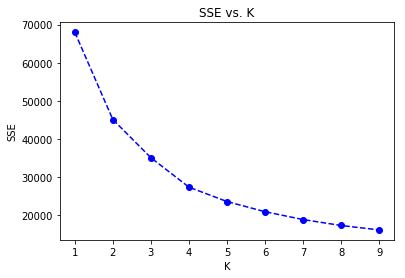

In [58]:
def get_kmeans_score(profile1, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(profile1)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(profile1))
    
    return score

scores = []
centers = list(range(1,10))

for center in centers:
    scores.append(get_kmeans_score(profile1_pca, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');


In [59]:
kmeans = KMeans(n_clusters=5)
model = kmeans.fit(profile1_pca)

In [60]:
labels_profile1= kmeans.predict(profile1_pca)

In [61]:
labels_profile1

array([3, 1, 3, ..., 0, 4, 1], dtype=int32)

In [62]:
labels_profile1 = pd.DataFrame(labels_profile1,columns = ['label'])

In [63]:
labels_profile1.label.value_counts()

0    5600
1    3867
4    3157
2    2192
3    2184
Name: label, dtype: int64

In [64]:
profile['label'] = labels_profile1

In [65]:
profile.head()

,age,became_member_on,gender,id,income,label
0,0,1.0,0.0,68be06ca386d4c31939f3a4f0e3dd783,0.0,3
1,4,1.0,2.0,0610b486422d4921ae7d2bf64640c50b,8.0,1
2,0,0.0,0.0,38fe809add3b4fcf9315a9694bb96ff5,0.0,3
3,6,1.0,2.0,78afa995795e4d85b5d9ceeca43f5fef,7.0,1
4,0,1.0,0.0,a03223e636434f42ac4c3df47e8bac43,0.0,3


In [66]:
transcript_offer1 = pd.DataFrame(transcript_offer.groupby(['person','event'])['time'].count().unstack())



In [67]:
transcript_offer1.fillna(0, inplace = True)

In [68]:
transcript_offer1['usage'] = (transcript_offer1['offer viewed'])/transcript_offer1['offer received']

In [69]:
transcript_amount.amount = transcript_amount.amount.astype(float)

In [70]:
transcript_amount1 = pd.DataFrame(transcript_amount.groupby(['person'])['amount'].sum())
transcript_amount1.head()

,amount
person,
0009655768c64bdeb2e877511632db8f,127.60
00116118485d4dfda04fdbaba9a87b5c,4.09
0011e0d4e6b944f998e987f904e8c1e5,79.46
0020c2b971eb4e9188eac86d93036a77,196.86
0020ccbbb6d84e358d3414a3ff76cffd,154.05


In [71]:
profile =pd.merge(profile,transcript_offer1,left_on = 'id',right_on = 'person')
profile =pd.merge(profile,transcript_amount1,left_on = 'id',right_on = 'person')


In [72]:
profile.head(10)

,age,became_member_on,gender,id,income,label,offer received,offer viewed,usage,amount
0,0,1.0,0.0,68be06ca386d4c31939f3a4f0e3dd783,0.0,3,5.0,5.0,1.00,20.40
1,4,1.0,2.0,0610b486422d4921ae7d2bf64640c50b,8.0,1,2.0,0.0,0.00,77.01
2,0,0.0,0.0,38fe809add3b4fcf9315a9694bb96ff5,0.0,3,2.0,2.0,1.00,14.30
3,6,1.0,2.0,78afa995795e4d85b5d9ceeca43f5fef,7.0,1,4.0,4.0,1.00,159.27
4,0,1.0,0.0,a03223e636434f42ac4c3df47e8bac43,0.0,3,5.0,3.0,0.60,4.65
5,5,0.0,1.0,e2127556f4f64592b11af22de27a7932,4.0,0,4.0,3.0,0.75,57.73
6,0,1.0,0.0,68617ca6246f4fbc85e91a2a49552598,0.0,3,5.0,4.0,0.80,0.24
7,5,0.0,1.0,389bc3fa690240e798340f5a15918d5c,3.0,0,6.0,6.0,1.00,36.43
8,0,2.0,0.0,8974fc5686fe429db53ddde067b88302,0.0,3,4.0,3.0,0.75,15.62
9,0,1.0,0.0,c4863c7985cf408faee930f111475da3,0.0,3,3.0,3.0,1.00,66.41


In [73]:
profile.describe()

,age,became_member_on,gender,income,label,offer received,offer viewed,usage,amount
count,16572.000000,16572.000000,16572.000000,16572.000000,16572.000000,16572.000000,16572.000000,16572.000000,16572.000000
mean,3.435252,1.385711,1.260198,3.461984,1.611936,4.489259,3.393254,0.759754,107.120526
std,1.892174,1.179669,0.684670,2.344314,1.504351,1.071717,1.290289,0.234991,126.409201
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.050000
25%,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,0.600000,23.687500
50%,4.000000,1.000000,1.000000,3.000000,1.000000,5.000000,3.000000,0.800000,72.435000
75%,5.000000,2.000000,2.000000,5.000000,3.000000,5.000000,4.000000,1.000000,150.940000
max,7.000000,5.000000,3.000000,8.000000,4.000000,6.000000,6.000000,1.000000,1608.690000


In [74]:
profile[profile.label == 0].describe()

,age,became_member_on,gender,income,label,offer received,offer viewed,usage,amount
count,5461.000000,5461.000000,5461.0,5461.000000,5461.0,5461.000000,5461.000000,5461.000000,5461.000000
mean,3.505951,0.805530,1.0,2.902582,0.0,4.495697,3.293170,0.736190,82.033210
std,1.429994,0.714767,0.0,1.415260,0.0,1.070171,1.284569,0.237768,107.742396
min,1.000000,0.000000,1.0,1.000000,0.0,1.000000,0.000000,0.000000,0.150000
25%,2.000000,0.000000,1.0,2.000000,0.0,4.000000,2.000000,0.600000,17.350000
50%,3.000000,1.000000,1.0,3.000000,0.0,5.000000,3.000000,0.750000,42.420000
75%,5.000000,1.000000,1.0,4.000000,0.0,5.000000,4.000000,1.000000,114.340000
max,7.000000,2.000000,1.0,7.000000,0.0,6.000000,6.000000,1.000000,1365.660000


In [75]:
profile[profile.label == 1].describe()

,age,became_member_on,gender,income,label,offer received,offer viewed,usage,amount
count,3755.000000,3755.000000,3755.000000,3755.000000,3755.0,3755.000000,3755.000000,3755.000000,3755.000000
mean,4.903329,1.388016,1.666844,6.575233,1.0,4.475899,3.348868,0.751669,179.736125
std,1.041994,0.831848,0.483126,1.114812,0.0,1.065586,1.295353,0.238379,158.495548
min,2.000000,0.000000,1.000000,4.000000,1.0,1.000000,0.000000,0.000000,2.010000
25%,4.000000,1.000000,1.000000,6.000000,1.0,4.000000,2.000000,0.600000,93.655000
50%,5.000000,1.000000,2.000000,7.000000,1.0,5.000000,3.000000,0.800000,149.170000
75%,6.000000,2.000000,2.000000,8.000000,1.0,5.000000,4.000000,1.000000,217.010000
max,7.000000,3.000000,3.000000,8.000000,1.0,6.000000,6.000000,1.000000,1608.690000


In [76]:
profile[profile.label == 2].describe()

,age,became_member_on,gender,income,label,offer received,offer viewed,usage,amount
count,2186.000000,2186.000000,2186.000000,2186.000000,2186.0,2186.000000,2186.000000,2186.000000,2186.000000
mean,3.711802,3.551235,1.293230,3.362763,2.0,4.473010,3.386551,0.761536,114.640457
std,1.456687,0.705247,0.462329,1.669120,0.0,1.086827,1.259175,0.226264,111.526825
min,1.000000,3.000000,1.000000,1.000000,2.0,1.000000,0.000000,0.000000,3.820000
25%,2.000000,3.000000,1.000000,2.000000,2.0,4.000000,3.000000,0.600000,47.007500
50%,4.000000,3.000000,1.000000,3.000000,2.0,5.000000,3.000000,0.800000,78.430000
75%,5.000000,4.000000,2.000000,4.000000,2.0,5.000000,4.000000,1.000000,152.407500
max,7.000000,5.000000,3.000000,7.000000,2.0,6.000000,6.000000,1.000000,1118.780000


In [77]:
profile[profile.label == 3].describe()

,age,became_member_on,gender,income,label,offer received,offer viewed,usage,amount
count,2094.000000,2094.000000,2094.000000,2094.000000,2094.0,2094.000000,2094.000000,2094.000000,2094.000000
mean,0.004298,1.298949,0.004298,0.004298,3.0,4.497135,3.599809,0.803152,19.639403
std,0.065434,1.020305,0.065434,0.065434,0.0,1.079161,1.315976,0.227197,19.544746
min,0.000000,0.000000,0.000000,0.000000,3.0,1.000000,0.000000,0.000000,0.050000
25%,0.000000,1.000000,0.000000,0.000000,3.0,4.000000,3.000000,0.666667,7.990000
50%,0.000000,1.000000,0.000000,0.000000,3.0,5.000000,4.000000,0.833333,15.795000
75%,0.000000,2.000000,0.000000,0.000000,3.0,5.000000,5.000000,1.000000,24.742500
max,1.000000,5.000000,1.000000,1.000000,3.0,6.000000,6.000000,1.000000,165.680000


In [78]:
profile[profile.label == 4].describe()

,age,became_member_on,gender,income,label,offer received,offer viewed,usage,amount
count,3076.000000,3076.000000,3076.000000,3076.000000,3076.0,3076.000000,3076.000000,3076.000000,3076.000000
mean,3.656697,0.933030,2.057217,3.078999,4.0,4.500325,3.489272,0.780651,117.223635
std,1.437644,0.737432,0.232295,1.368853,0.0,1.066413,1.276510,0.231363,113.237627
min,1.000000,0.000000,2.000000,1.000000,4.0,1.000000,0.000000,0.000000,0.410000
25%,2.000000,0.000000,2.000000,2.000000,4.0,4.000000,3.000000,0.600000,37.620000
50%,4.000000,1.000000,2.000000,3.000000,4.0,5.000000,3.500000,0.800000,95.695000
75%,5.000000,1.000000,2.000000,4.000000,4.0,5.000000,4.000000,1.000000,159.792500
max,7.000000,3.000000,3.000000,7.000000,4.0,6.000000,6.000000,1.000000,1327.740000
